In [1]:
# load weight from model
import os
from Module.model import return_resnet

# get model
class_map = {
    80: 0, 
    56: 1, 
    43: 2, 
    53: 3, 
    45: 4, 
    42: 5,
    54: 6, 
    41: 7
    #(55, 8)
}

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = "0"


checkpoint_dir  = "/workspace/skin/checkpoint/"
reload_file = "512loss_acc_S5B50_AUG.ckpt"
checkpoint_path = checkpoint_dir+reload_file

# reload model
model = return_resnet("R-50-v1", classNum=len(class_map))
model.load_weights(checkpoint_path)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [30]:
from hephaestus.data.ndpwrapper_v2 import Slide_ndpread
from skimage.color import rgb2hsv
import numpy as np
import time

type_dictionary = {
    0: "muscle",
    1: "inflammatory infiltration",
    2: "adipose tissue",
    3: "sweat gland",
    4: "hair follicles",
    5: "dermis",
    6: "sebaceous gland",
    7: "epidermis",
    8: "background"
    #8: "blood vessel"
}

SLIDE_LIST = [
"2019-10-30 02.05.46.ndpi",
"2019-10-30 02.04.50.ndpi",
"2019-10-30 02.09.05.ndpi",
"2019-10-30 02.07.27.ndpi",
"2019-10-30 02.10.47.ndpi",
"2019-10-30 02.14.37.ndpi",
"2019-10-30 02.18.03.ndpi",
"2019-10-30 02.19.24.ndpi",
"2019-10-30 02.15.32.ndpi",
"2019-10-30 02.23.07.ndpi",
"2019-10-30 01.59.42.ndpi",
"350013D01170 - 2019-10-30 02.21.40.ndpi",
"2019-10-30 02.01.19.ndpi",
"2019-10-30 02.02.21.ndpi",
"2019-10-30 02.03.40.ndpi",
"2019-10-30 02.05.46.ndpi"]


class SlidePredictor:
    def __init__(self, 
                 bbox_shape, 
                 slide_dir,
                 slide_name,
                 histologic_name,
                 classifier,
                 class_map,
                 batch_size=32
                ):
        self.bbox_shape = bbox_shape
        self.slide_dir  = slide_dir
        self.slide_name = slide_name
        self.histologic_name = histologic_name
        self.classifier = classifier
        self.batch_size = batch_size
        self.colormap   = [
            "tomato",
            "chocolate",
            "tan",
            "gold",
            "olive",
            "palegreen",
            "cyan",
            "navy",
            "white"
        ]
        if class_map is None:
            self.class_map = {
                80: 0, 
                56: 1, 
                43: 2, 
                53: 3, 
                45: 4, 
                42: 5,
                54: 6, 
                41: 7
                #(55, 8)
            }
        else:
            self.class_map=class_map
        
        self.this_slide = Slide_ndpread(os.path.join(slide_dir, slide_name))
        W, H = self.this_slide.get_size()
        w, h = bbox_shape[0], bbox_shape[1]
        self.W = W
        self.H = H
        
        self.w_stride = W//w if W%w==0 else W//w+1
        self.h_stride = H//h if H%h==0 else H//h+1
        self.prob_map = np.zeros((self.w_stride, self.h_stride, len(self.class_map)), dtype=np.float32)
        self.tiny_slide = self.this_slide.get_patch_with_resize(coord=(0, 0), 
                                            src_sz=(W, H),
                                            dst_sz=(self.w_stride, self.h_stride))
        self.background_mask = self._judge_bg()
        
        #self._background_test()
        self._get_prob_map()
    
    def _judge_bg(self):
        hsv_img = rgb2hsv(self.tiny_slide)
        saturation_img = hsv_img[:, :, 1]
        return np.array(saturation_img<0.05)
        
    
    def _get_prob_map(self):
        # 277*76
        patches = []
        coords  = []
        for i in range(self.w_stride):
            begin_time = time.time()
            for j in range(self.h_stride):
                patch = self.this_slide.get_patch_at_level((512*i, 512*j), 
                                                                  self.bbox_shape)/255.
                if not self.background_mask[j, i]:
                    patches.append(patch)
                    coords.append((i, j))
                    if len(patches)%self.batch_size==31:
                        preds = self.classifier(np.array(patches, dtype=np.float32)).numpy()
                        for idx, coord in enumerate(coords):
                            self.prob_map[coord[0], coord[1]] = np.copy(preds[idx])
                        patches.clear()
                        coords.clear()
            end_time = time.time()
            print("Column {:}/{:}: time elapse {:}".format(i, self.w_stride, end_time-begin_time), end='\r')
        
        if len(patches):
            preds = self.classifier(np.array(patches, dtype=np.float32)).numpy()
            for idx, coord in enumerate(coords):
                self.prob_map[coord[0], coord[1]] = np.copy(preds[idx])
            patches.clear()
            coords.clear()
        
        predicted_cls = np.array([[np.argmax(self.prob_map[i,j]) for i in range(self.prob_map.shape[0])] 
                         for j in range(self.prob_map.shape[1])])
        predicted_cls[self.background_mask] = len(self.class_map)
        
    def _background_test(self):
        '''
            normalized to 0~1:
            background std: 0.0017
            background mean: 0.93
        '''
        std  = []
        mean = []
        for i in range(0, self.w_stride, 10):
            for j in range(self.h_stride):
                patch = self.this_slide.get_patch_at_level((512*i, 512*j), self.bbox_shape)/255.
                std.append(np.std(patch))
                mean.append(np.mean(patch))
        print("{:}: std median {:04f}, mean median {: 03f}".format(self.slide_name,
                                                                  np.median(np.array(std)),
                                                                  np.median(np.array(mean))))
        
            
    def visualize_predict(self, axis):
        predicted_cls = np.array([[np.argmax(self.prob_map[i,j]) for i in range(self.prob_map.shape[0])] 
                         for j in range(self.prob_map.shape[1])])
        predicted_cls[self.background_mask] = len(self.class_map)
        
        w_s, h_s = self.w_stride, self.h_stride
        x = np.array([i for j in range(h_s)for i in range(w_s)])
        y = np.array([j for j in range(h_s)for i in range(w_s)])
        assert len(x) == len(y)
        classes = [predicted_cls[y[i], x[i]] for i in range(len(x))]
        for cls in np.unique(classes):
            ix = np.where(classes == cls)
            axis.scatter(x[ix], y[ix], c = self.colormap[cls], 
                         label = self.histologic_name[cls], marker='s', s=8)
        axis.legend(loc="lower right", bbox_to_anchor=(1,1), ncol=4, fontsize=10, markerscale=2)
        #axis.scatter(x, y, color=color)
        axis.set_xlim([0, w_s])
        axis.set_ylim([0, h_s])
    
    def get_np_pred(self):
        back  = np.zeros((self.w_stride, self.h_stride, 1))
        back[self.background_mask.transpose()] = 1
        ret = np.concatenate([self.prob_map, back], axis=2)
        return ret.transpose((1,0,2)).reshape((-1, ret.shape[2]))

    def get_shape(self):
        return self.W, self.H

myPredictor = SlidePredictor(bbox_shape=(512,512),
                             slide_dir = "/mnt/cephrbd/data/A19001_NCKU_SKIN/Image/20191106/",
                             #slide_name = slide_name,
                             slide_name = "2019-10-30 02.01.19.ndpi",
                             histologic_name = type_dictionary,
                             classifier = model,
                             class_map = class_map
                            )

print(myPredictor.get_np_pred())


Width: 142080 , Height: 39168
[[0. 0. 0. ... 0. 0. 1.]pse 0.63350439071655277
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


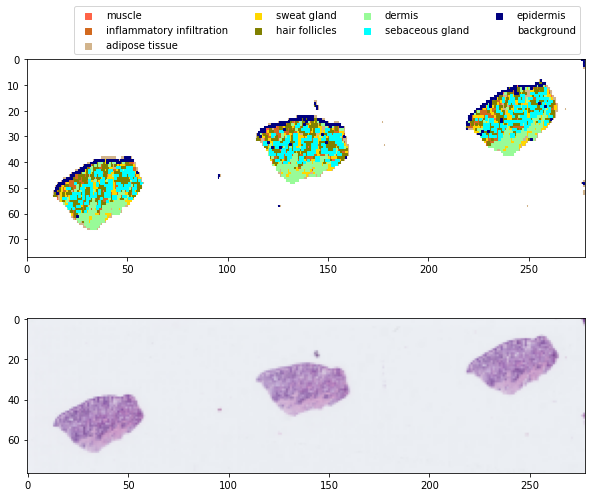

In [32]:
import matplotlib.pyplot as plt
    
fig1 = plt.figure(figsize = (10, 8))
ax = fig1.add_subplot(2,1,1)

myPredictor.visualize_predict(ax)
plt.gca().invert_yaxis()

ax = fig1.add_subplot(2,1,2)
ax.imshow(myPredictor.tiny_slide)
#plt.savefig("result/02.23.07_result.png")
plt.show()

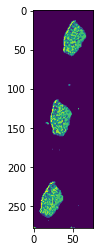

In [33]:
plt.imshow(myPredictor.prob_map.argmax(axis=-1))

In [34]:
from hephaestus.compose.wsi_patch.api import PatchResultPostprocess

In [35]:
PRP = PatchResultPostprocess(patch_size=512, raw_h=myPredictor.this_slide.get_size()[1]-512,
                             raw_w=myPredictor.this_slide.get_size()[0]-512, blur=0.)

In [36]:
myPredictor.this_slide.get_size()

(142080, 39168)

In [37]:
tmp = myPredictor.prob_map

print(tmp.shape)
back  = np.zeros((myPredictor.w_stride, myPredictor.h_stride, 1))
back[myPredictor.background_mask.transpose()] = 1
out = np.concatenate([tmp, back], axis=2)
print(out)

(278, 77, 8)
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
   0.00000000e+00 1.00000000e+00]
  ...
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+

In [38]:
out.shape

(278, 77, 9)

In [44]:
'''
root@80f26a2f0117:/workspace/skin# cd /mnt/cephrbd/data/A19001_NCKU_SKIN/Meta/
root@80f26a2f0117:/mnt/cephrbd/data/A19001_NCKU_SKIN/Meta# cat annot-pk-reference.json 
{
    "80": "Muscle",
    "56": "Inflammatory infiltration",
    "55": "Blood vessel",
    "54": "Sebaceous gland",
    "53": "Sweat gland",
    "45": "Hair follicle",
    "44": "Unspecified",
    "43": "Adipose tissue",
    "42": "Dermis (Collagen fiber and fibroblasts)",
    "41": "Epidermis"
}
'''
result_dir = "/workspace/skin/result/inference_CSV/"
target_folder= os.path.join(result_dir, "12345")
if not os.path.exists(target_folder):
    os.makedirs(target_folder)
d = PRP.run(prediction=myPredictor.get_np_pred(),  
            result_dir=result_dir, target_folder=target_folder)
print(d)

{'slide_name': '12345', 'default_threshold': '0.700', 'tile_size': 512, 'meta_path': '/workspace/skin/result/inference_CSV/12345/df.csv', 'layer_map': {'0.100': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.100.png', 'score': 0}, '0.200': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.200.png', 'score': 0}, '0.300': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.300.png', 'score': 0}, '0.400': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.400.png', 'score': 0}, '0.500': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.500.png', 'score': 0}, '0.600': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.600.png', 'score': 0}, '0.700': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.700.png', 'score': 0}, '0.800': {'path': '/workspace/skin/result/inference_CSV/12345/alpha_thres-0.800.png', 'score': 0}, '0.900': {'path': '/workspace/skin/result/inference_CSV/

In [45]:
import pandas
d = pandas.read_csv(target_folder+"/df.csv")
d

,w,h,pred_as_0,pred_as_1,pred_as_2,pred_as_3,pred_as_4,pred_as_5,pred_as_6,pred_as_7,pred_as_8
0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
21047,272,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21048,273,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21049,274,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21050,275,75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [99]:
import matplotlib.image as mpimg

slide_list = [
"2019-10-30 01.59.42.",
"2019-10-30 02.01.19.",
"2019-10-30 02.02.21.",
"2019-10-30 02.03.40.",
"2019-10-30 02.04.50.",
"2019-10-30 02.05.46.",
"2019-10-30 02.07.27.",
"2019-10-30 02.09.05.",
"2019-10-30 02.10.47.",
"2019-10-30 02.14.37.",
"2019-10-30 02.15.32.",
"2019-10-30 02.18.03.",
"2019-10-30 02.19.24.",
"2019-10-30 02.23.07.",
"350013D01170 - 2019-10-30 02.21.40."   
]

def plot_threshold(fig, slide_name):
    for i in range(10):
        ax = fig.add_subplot(5, 2, i+1)
        img = mpimg.imread('result/inference_CSV/'+slide_name+'/alpha_thres-0.'+str(i)+'00.png')
        ax.set_xticks([])
        ax.set_yticks([])
        ax_title = "Slide:"+ slide_name + ", alpha threshold={:.1f}".format(0.1*i)
        ax.set_title(ax_title,fontsize=12)
        ax.imshow(img, interpolation='nearest')
    fig.tight_layout()
    import os
    save_path = "/workspace/skin/result/heatmap/"
    if not os.path.isdir(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path, slide_name))
    plt.clf() 
    
fig2 = plt.figure(figsize=(20, 15))
for i in range(len(slide_list)):
    plot_threshold(fig2, slide_list[i])

<Figure size 1440x1080 with 0 Axes>